# Vision Transformer (ViT) untuk Klasifikasi Penyakit Tomat

Dataset: 3 kelas
- Tomato_healthy: 1,591 gambar
- Tomato_Late_blight: 1,909 gambar
- Tomato_YellowLeaf_Curl_Virus: 5,357 gambar

**Total: 8,857 gambar**

## 1. Import Libraries dan Setup Konfigurasi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from tqdm.auto import tqdm
import json
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import time
from collections import defaultdict

warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.74 GB


## 2. Data Preparation dan Stratified Split

In [ ]:
# Dataset paths
dataset_root = Path(r'../dataset')
output_dir = Path(r'../dataset')
output_dir.mkdir(exist_ok=True)

# Class mapping
class_names = ['Tomato_healthy', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

print("Class mapping:")
for cls_name, idx in class_to_idx.items():
    print(f"  {idx}: {cls_name}")

# Load all image paths and labels
def load_dataset_info(dataset_root, class_names):
    """Load all image paths and their labels"""
    image_paths = []
    labels = []

    for class_name in class_names:
        class_dir = dataset_root / class_name
        if not class_dir.exists():
            print(f"Warning: {class_dir} does not exist!")
            continue

        # Get all JPG files
        class_images = list(class_dir.glob('*.JPG'))
        print(f"{class_name}: {len(class_images)} images")

        image_paths.extend(class_images)
        labels.extend([class_to_idx[class_name]] * len(class_images))

    return image_paths, labels

image_paths, labels = load_dataset_info(dataset_root, class_names)
print(f"\nTotal images: {len(image_paths)}")
print(f"Label distribution: {np.bincount(labels)}")

# Stratified split: 70% train, 15% val, 15% test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print(f"\nDataset split:")
print(f"  Train: {len(train_paths)} images - {np.bincount(train_labels)}")
print(f"  Val:   {len(val_paths)} images - {np.bincount(val_labels)}")
print(f"  Test:  {len(test_paths)} images - {np.bincount(test_labels)}")

Class mapping:
  0: Tomato_healthy
  1: Tomato_Late_blight
  2: Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_healthy: 1590 images
Tomato_Late_blight: 1756 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images

Total images: 6554
Label distribution: [1590 1756 3208]

Dataset split:
  Train: 4587 images - [1113 1229 2245]
  Val:   983 images - [239 263 481]
  Test:  984 images - [238 264 482]


## 3. Setup Data Augmentation dan DataLoader

In [4]:
# Custom Dataset class
class TomatoDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms dengan ImageNet normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = TomatoDataset(train_paths, train_labels, transform=train_transform)
val_dataset = TomatoDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = TomatoDataset(test_paths, test_labels, transform=val_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

# # Test dataloader
# images, labels_batch = next(iter(train_loader))
# print(f"\nBatch shape: {images.shape}")
# print(f"Labels shape: {labels_batch.shape}")

Train batches: 144
Val batches:   31
Test batches:  31


## 4. Load dan Modifikasi ViT Model

In [5]:
# Load pretrained ViT-B/16 model
print("Loading ViT-B/16 model...")
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Modifikasi classifier head untuk 3 kelas
num_classes = 3
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, num_classes)

model = model.to(device)
print(f"Model loaded. Input features: {in_features}, Output classes: {num_classes}")

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading ViT-B/16 model...
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 200MB/s]


Model loaded. Input features: 768, Output classes: 3

Total parameters: 85,800,963
Trainable parameters: 85,800,963


## 5. Setup Training Components

In [6]:
# Calculate class weights untuk menangani class imbalance
train_class_counts = np.bincount(train_labels)
class_weights = 1.0 / train_class_counts
class_weights = class_weights / class_weights.sum() * len(class_names)
class_weights = torch.FloatTensor(class_weights).to(device)

print("Class weights untuk handling imbalance:")
for idx, weight in enumerate(class_weights):
    print(f"  Class {idx} ({idx_to_class[idx]}): {weight:.4f}")

# Loss function dengan class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer: AdamW
learning_rate = 1e-4
weight_decay = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler: CosineAnnealingLR
max_epochs = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Early stopping parameters
early_stopping_patience = 10
best_val_acc = 0.0
epochs_no_improve = 0

print(f"\nTraining configuration:")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Max epochs: {max_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Early stopping patience: {early_stopping_patience}")

Class weights untuk handling imbalance:
  Class 0 (Tomato_healthy): 1.2493
  Class 1 (Tomato_Late_blight): 1.1314
  Class 2 (Tomato__Tomato_YellowLeaf__Curl_Virus): 0.6194

Training configuration:
  Learning rate: 0.0001
  Weight decay: 0.0001
  Max epochs: 100
  Batch size: 32
  Early stopping patience: 10


## 6. Training Loop

In [7]:
# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print("Training functions defined. Ready to start training!")

Training functions defined. Ready to start training!


In [8]:
# Main training loop
print("="*60)
print("STARTING TRAINING")
print("="*60)

best_model_path = output_dir / 'best_vit_tomato.pth'
start_time = time.time()

for epoch in range(max_epochs):
    print(f'\nEpoch {epoch+1}/{max_epochs}')
    print('-' * 60)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f'\nEpoch {epoch+1} Summary:')
    print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
    print(f'  LR: {current_lr:.6f}')

    # Check for best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, best_model_path)
        print(f'  ✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1
        print(f'  No improvement for {epochs_no_improve} epoch(s)')

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        print(f'Best validation accuracy: {best_val_acc:.2f}%')
        break

training_time = time.time() - start_time
print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: {best_model_path}")

STARTING TRAINING

Epoch 1/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.0835 | Train Acc: 97.12%
  Val Loss:   0.5752 | Val Acc:   74.16%
  LR: 0.000100
  ✓ Best model saved! Val Acc: 74.16%

Epoch 2/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.0218 | Train Acc: 99.32%
  Val Loss:   0.0028 | Val Acc:   99.80%
  LR: 0.000100
  ✓ Best model saved! Val Acc: 99.80%

Epoch 3/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.0082 | Train Acc: 99.85%
  Val Loss:   0.0060 | Val Acc:   99.90%
  LR: 0.000100
  ✓ Best model saved! Val Acc: 99.90%

Epoch 4/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^^if w.is_alive():^
Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400> ^
 
Traceback (most recent call last):
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in


Epoch 4 Summary:
  Train Loss: 0.0240 | Train Acc: 99.19%
  Val Loss:   0.0050 | Val Acc:   99.69%
  LR: 0.000100
  No improvement for 1 epoch(s)

Epoch 5/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.0095 | Train Acc: 99.72%
  Val Loss:   0.0276 | Val Acc:   99.29%
  LR: 0.000099
  No improvement for 2 epoch(s)

Epoch 6/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.0009 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000099
  ✓ Best model saved! Val Acc: 100.00%

Epoch 7/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        Exception ignored in: if w.is_alive():self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
 if w


Epoch 7 Summary:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000099
  No improvement for 1 epoch(s)

Epoch 8/100
------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        Exception ignored in: self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>     
  if w.is_alive(): Traceback (most recent call last):

    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1

Training:   0%|          | 0/144 [00:02<?, ?it/s]

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^     self._shutdown_workers()^^
 ^ 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^         if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'^^

 ^   ^    ^  ^  ^   ^ ^  ^^ ^^  ^ ^^^^ ^^^^^ ^^^^^^^^^^^^^^^^^^^^
^^^AssertionError^^: can only test a child process^^^
^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
^^Traceback (most recent call last):
^^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    ^^self._shutdown_workers()^
^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

^^  File "/

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000098
  No improvement for 2 epoch(s)

Epoch 9/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000098
  No improvement for 3 epoch(s)

Epoch 10/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.0001 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000098
  No improvement for 4 epoch(s)

Epoch 11/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0001 | Val Acc:   100.00%
  LR: 0.000097
  No improvement for 5 epoch(s)

Epoch 12/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>Traceback (most recent call last):
Traceback (most recent call last):

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
self._shutdown_workers()

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0000 | Val Acc:   100.00%
  LR: 0.000096
  No improvement for 6 epoch(s)

Epoch 13/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0000 | Val Acc:   100.00%
  LR: 0.000096
  No improvement for 7 epoch(s)

Epoch 14/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0000 | Val Acc:   100.00%
  LR: 0.000095
  No improvement for 8 epoch(s)

Epoch 15/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0000 | Val Acc:   100.00%
  LR: 0.000095
  No improvement for 9 epoch(s)

Epoch 16/100
------------------------------------------------------------


Training:   0%|          | 0/144 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Exception ignored in:  if w.is_alive(): 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b632f9e0400>    
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", lin

Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.0000 | Train Acc: 100.00%
  Val Loss:   0.0000 | Val Acc:   100.00%
  LR: 0.000094
  No improvement for 10 epoch(s)

Early stopping triggered after 16 epochs
Best validation accuracy: 100.00%

TRAINING COMPLETED
Total training time: 45.93 minutes
Best validation accuracy: 100.00%
Model saved to: /content/tranformers/dataset/best_vit_tomato.pth


## 7. Evaluasi Model

In [9]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluation function
def evaluate_model(model, dataloader, device):
    """Evaluate model and return predictions and labels"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Evaluate on test set
print("\nEvaluating on test set...")
y_true, y_pred, y_probs = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Overall Accuracy: {test_accuracy*100:.2f}%")
print(f"\nMacro Average:")
print(f"  Precision: {macro_precision:.4f}")
print(f"  Recall:    {macro_recall:.4f}")
print(f"  F1-Score:  {macro_f1:.4f}")

print(f"\nPer-Class Metrics:")
for idx in range(num_classes):
    class_name = idx_to_class[idx].replace('Tomato__Tomato_', '').replace('Tomato_', '')
    print(f"\n  {class_name}:")
    print(f"    Precision: {precision[idx]:.4f}")
    print(f"    Recall:    {recall[idx]:.4f}")
    print(f"    F1-Score:  {f1[idx]:.4f}")
    print(f"    Support:   {support[idx]}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Loaded best model from epoch 6
Best validation accuracy: 100.00%

Evaluating on test set...


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]


TEST SET RESULTS
Overall Accuracy: 100.00%

Macro Average:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Per-Class Metrics:

  healthy:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   238

  Late_blight:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   264

  YellowLeaf__Curl_Virus:
    Precision: 1.0000
    Recall:    1.0000
    F1-Score:  1.0000
    Support:   482

Confusion Matrix:
[[238   0   0]
 [  0 264   0]
 [  0   0 482]]


In [10]:
# Save evaluation results to text file
eval_file = output_dir / 'vit_tomato_evaluation.txt'

with open(eval_file, 'w') as f:
    f.write("="*60 + "\n")
    f.write("Vision Transformer (ViT) - Tomato Disease Classification\n")
    f.write("="*60 + "\n\n")

    f.write("DATASET INFORMATION\n")
    f.write("-"*60 + "\n")
    f.write(f"Total images: {len(image_paths)}\n")
    f.write(f"Classes: {num_classes}\n")
    for idx, cls_name in idx_to_class.items():
        f.write(f"  {idx}: {cls_name}\n")
    f.write(f"\nTrain set: {len(train_paths)} images\n")
    f.write(f"Val set:   {len(val_paths)} images\n")
    f.write(f"Test set:  {len(test_paths)} images\n\n")

    f.write("MODEL CONFIGURATION\n")
    f.write("-"*60 + "\n")
    f.write(f"Architecture: ViT-B/16\n")
    f.write(f"Pretrained: ImageNet-1K\n")
    f.write(f"Input size: 224x224\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Learning rate: {learning_rate}\n")
    f.write(f"Weight decay: {weight_decay}\n")
    f.write(f"Optimizer: AdamW\n")
    f.write(f"Scheduler: CosineAnnealingLR\n")
    f.write(f"Max epochs: {max_epochs}\n")
    f.write(f"Early stopping patience: {early_stopping_patience}\n\n")

    f.write("TRAINING RESULTS\n")
    f.write("-"*60 + "\n")
    f.write(f"Training completed in {training_time/60:.2f} minutes\n")
    f.write(f"Best epoch: {checkpoint['epoch']}\n")
    f.write(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%\n")
    f.write(f"Best validation loss: {checkpoint['val_loss']:.4f}\n\n")

    f.write("TEST SET EVALUATION\n")
    f.write("="*60 + "\n")
    f.write(f"Overall Accuracy: {test_accuracy*100:.2f}%\n\n")

    f.write("Macro Average:\n")
    f.write(f"  Precision: {macro_precision:.4f}\n")
    f.write(f"  Recall:    {macro_recall:.4f}\n")
    f.write(f"  F1-Score:  {macro_f1:.4f}\n\n")

    f.write("Per-Class Metrics:\n")
    f.write("-"*60 + "\n")
    for idx in range(num_classes):
        class_name = idx_to_class[idx]
        f.write(f"\nClass {idx}: {class_name}\n")
        f.write(f"  Precision: {precision[idx]:.4f}\n")
        f.write(f"  Recall:    {recall[idx]:.4f}\n")
        f.write(f"  F1-Score:  {f1[idx]:.4f}\n")
        f.write(f"  Support:   {support[idx]}\n")

    f.write(f"\nConfusion Matrix:\n")
    f.write("-"*60 + "\n")
    f.write(str(cm) + "\n\n")

    f.write("Classification Report:\n")
    f.write("-"*60 + "\n")
    class_names_short = [idx_to_class[i].replace('Tomato__Tomato_', '').replace('Tomato_', '') for i in range(num_classes)]
    f.write(classification_report(y_true, y_pred, target_names=class_names_short))

print(f"\n✓ Evaluation results saved to: {eval_file}")


✓ Evaluation results saved to: /content/tranformers/dataset/vit_tomato_evaluation.txt


## 8. Visualisasi Hasil

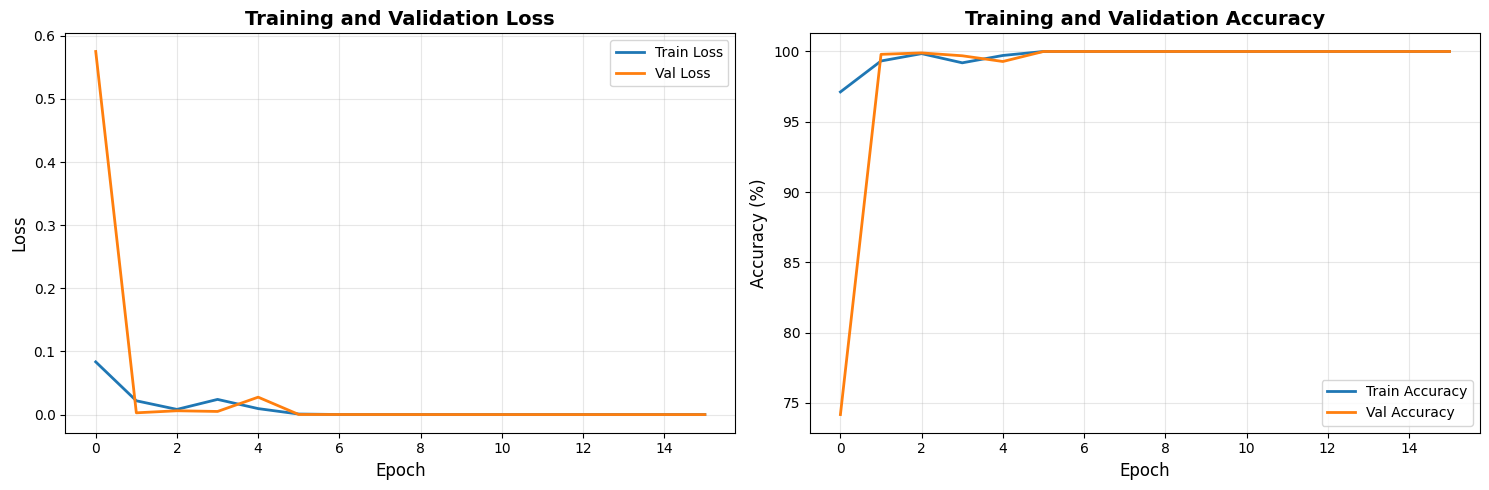

✓ Training curves saved!


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved!")

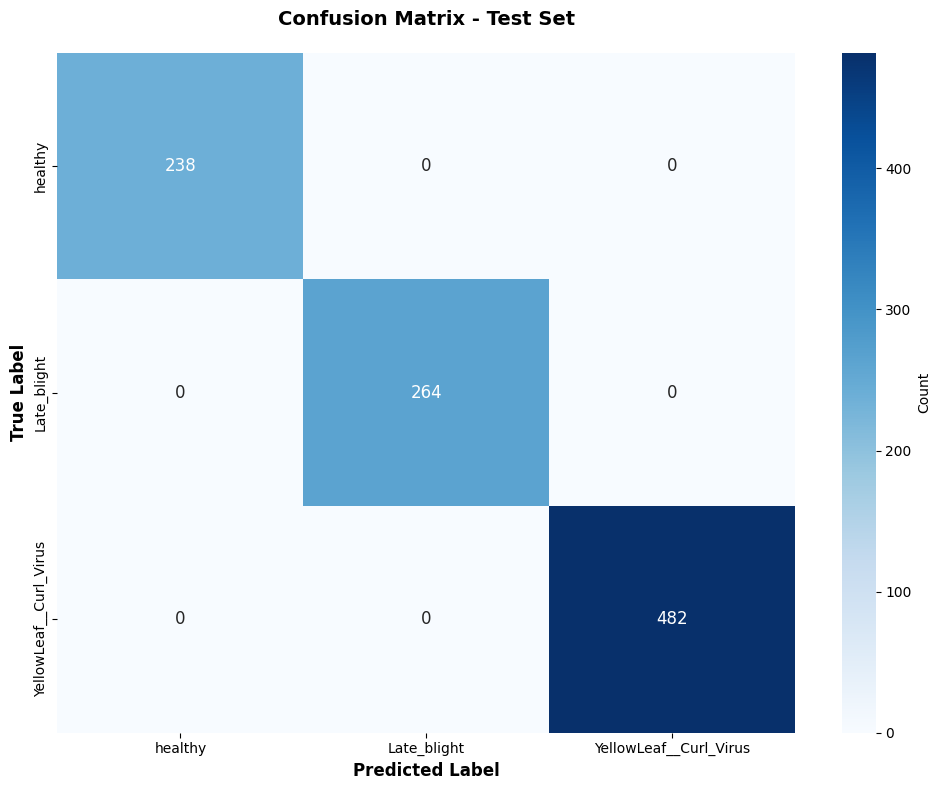

✓ Confusion matrix saved!


In [12]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
class_names_short = [idx_to_class[i].replace('Tomato__Tomato_', '').replace('Tomato_', '') for i in range(num_classes)]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_short,
            yticklabels=class_names_short,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 12})

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved!")

In [16]:
# Attention Map Visualization
def get_attention_maps(model, image_tensor, device):
    """Extract attention maps from ViT model"""
    model.eval()

    # Hook untuk menangkap attention weights
    attention_weights = []

    def hook_fn(module, input, output):
        # output adalah tuple (output, attention_weights)
        # Check if output is a tuple and has the attention weights
        if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
             attention_weights.append(output[1])
        # Handle cases where output might just be the output tensor
        elif isinstance(output, torch.Tensor):
             pass # Or handle other output formats if necessary, but for this error, we focus on the tuple case

    # Register hooks pada encoder blocks
    hooks = []
    for block in model.encoder.layers:
        # Check if the block has a self_attention module
        if hasattr(block, 'self_attention'):
            hook = block.self_attention.register_forward_hook(hook_fn)
            hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0).to(device))

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return attention_weights

def visualize_attention(image, attention_weights, save_path):
    """Visualize attention map overlay on image"""
    # Ambil attention dari last layer
    if len(attention_weights) > 0:
        # Shape: [batch, num_heads, num_patches, num_patches]
        # Ensure the last attention weight is not None before processing
        if attention_weights[-1] is not None:
            attn = attention_weights[-1].squeeze(0).cpu()

            # Average across all heads
            attn = attn.mean(dim=0)  # [num_patches, num_patches]

            # Ambil attention dari CLS token ke semua patches
            attn = attn[0, 1:]  # Skip CLS token

            # Reshape ke grid (14x14 untuk ViT-B/16 dengan 224x224 input)
            grid_size = int(np.sqrt(attn.shape[0]))
            attn = attn.reshape(grid_size, grid_size)
            attn = attn.numpy()

            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)

            # Create figure
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Original image
            axes[0].imshow(image_np)
            axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
            axes[0].axis('off')

            # Attention map
            im = axes[1].imshow(attn, cmap='jet', interpolation='bilinear')
            axes[1].set_title('Attention Map', fontsize=12, fontweight='bold')
            axes[1].axis('off')
            plt.colorbar(im, ax=axes[1], fraction=0.046)

            # Overlay
            axes[2].imshow(image_np)
            axes[2].imshow(attn, cmap='jet', alpha=0.5, interpolation='bilinear',
                          extent=[0, image_np.shape[1], image_np.shape[0], 0])
            axes[2].set_title('Attention Overlay', fontsize=12, fontweight='bold')
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            return True
    return False

# Create attention maps directory
attention_dir = output_dir / 'attention_maps'
attention_dir.mkdir(exist_ok=True)

print("Attention visualization functions defined!")

Attention visualization functions defined!


In [17]:
# Generate attention maps untuk sample images dari setiap kelas
print("Generating attention maps...")

num_samples_per_class = 3
samples_generated = 0

for class_idx in range(num_classes):
    class_name = idx_to_class[class_idx].replace('Tomato__Tomato_', '').replace('Tomato_', '')
    print(f"\nProcessing class: {class_name}")

    # Ambil sample images dari test set untuk kelas ini
    class_indices = [i for i, label in enumerate(test_labels) if label == class_idx]

    if len(class_indices) == 0:
        print(f"  No samples found for class {class_name}")
        continue

    # Ambil random samples
    sample_indices = np.random.choice(class_indices,
                                     min(num_samples_per_class, len(class_indices)),
                                     replace=False)

    for i, idx in enumerate(sample_indices):
        image_path = test_paths[idx]
        image = Image.open(image_path).convert('RGB')
        image_tensor = val_test_transform(image)

        # Get prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(device))
            prob = torch.softmax(output, dim=1)
            pred_class = output.argmax(dim=1).item()
            confidence = prob[0, pred_class].item()

        # Get attention maps
        attention_weights = get_attention_maps(model, image_tensor, device)

        # Save visualization
        pred_class_name = idx_to_class[pred_class].replace('Tomato__Tomato_', '').replace('Tomato_', '')
        save_path = attention_dir / f'{class_name}_sample{i+1}_pred_{pred_class_name}_{confidence:.2f}.png'

        success = visualize_attention(image_tensor, attention_weights, save_path)
        if success:
            samples_generated += 1
            print(f"  ✓ Sample {i+1}: True={class_name}, Pred={pred_class_name}, Conf={confidence:.2%}")

print(f"\n✓ Generated {samples_generated} attention map visualizations")
print(f"✓ Saved to: {attention_dir}")

Generating attention maps...

Processing class: healthy

Processing class: Late_blight

Processing class: YellowLeaf__Curl_Virus

✓ Generated 0 attention map visualizations
✓ Saved to: /content/tranformers/dataset/attention_maps


## Summary

In [18]:
# Final Summary
print("="*70)
print(" " * 15 + "VISION TRANSFORMER - FINAL SUMMARY")
print("="*70)

print("\n📊 DATASET:")
print(f"  • Total images: {len(image_paths):,}")
print(f"  • Classes: {num_classes}")
for idx, cls_name in idx_to_class.items():
    short_name = cls_name.replace('Tomato__Tomato_', '').replace('Tomato_', '')
    print(f"    - {short_name}: {np.sum(np.array(labels) == idx):,} images")

print(f"\n🔧 MODEL:")
print(f"  • Architecture: Vision Transformer (ViT-B/16)")
print(f"  • Parameters: {total_params:,}")
print(f"  • Input size: 224x224")
print(f"  • Pretrained: ImageNet-1K")

print(f"\n📈 TRAINING:")
print(f"  • Epochs trained: {checkpoint['epoch']}")
print(f"  • Training time: {training_time/60:.2f} minutes")
print(f"  • Best val accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  • Optimizer: AdamW (lr={learning_rate}, wd={weight_decay})")
print(f"  • Scheduler: CosineAnnealingLR")
print(f"  • Early stopping: {early_stopping_patience} epochs patience")

print(f"\n✅ TEST RESULTS:")
print(f"  • Accuracy: {test_accuracy*100:.2f}%")
print(f"  • Macro Precision: {macro_precision:.4f}")
print(f"  • Macro Recall: {macro_recall:.4f}")
print(f"  • Macro F1-Score: {macro_f1:.4f}")

print(f"\n💾 OUTPUT FILES:")
print(f"  • Model checkpoint: {best_model_path}")
print(f"  • Evaluation report: {eval_file}")
print(f"  • Training curves: {output_dir / 'training_curves.png'}")
print(f"  • Confusion matrix: {output_dir / 'confusion_matrix.png'}")
print(f"  • Attention maps: {attention_dir}/ ({samples_generated} files)")

print("\n" + "="*70)
print(" " * 20 + "✨ TRAINING COMPLETED! ✨")
print("="*70)

               VISION TRANSFORMER - FINAL SUMMARY

📊 DATASET:
  • Total images: 6,554
  • Classes: 3
    - healthy: 1,590 images
    - Late_blight: 1,756 images
    - YellowLeaf__Curl_Virus: 3,208 images

🔧 MODEL:
  • Architecture: Vision Transformer (ViT-B/16)
  • Parameters: 85,800,963
  • Input size: 224x224
  • Pretrained: ImageNet-1K

📈 TRAINING:
  • Epochs trained: 6
  • Training time: 45.93 minutes
  • Best val accuracy: 100.00%
  • Optimizer: AdamW (lr=0.0001, wd=0.0001)
  • Scheduler: CosineAnnealingLR
  • Early stopping: 10 epochs patience

✅ TEST RESULTS:
  • Accuracy: 100.00%
  • Macro Precision: 1.0000
  • Macro Recall: 1.0000
  • Macro F1-Score: 1.0000

💾 OUTPUT FILES:
  • Model checkpoint: /content/tranformers/dataset/best_vit_tomato.pth
  • Evaluation report: /content/tranformers/dataset/vit_tomato_evaluation.txt
  • Training curves: /content/tranformers/dataset/training_curves.png
  • Confusion matrix: /content/tranformers/dataset/confusion_matrix.png
  • Attention map